### Download dataset from Kaggle, fashion_mnist

todo: explain why we choose to use fashion_mnist

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

training_set = pd.read_csv('Dataset/fashion_data/fashion-mnist_train.csv')
test_set = pd.read_csv('Dataset/fashion_data/fashion-mnist_test.csv')

print(training_set.shape)
print(test_set.shape)

(60000, 785)
(10000, 785)


perform data cleaning

In [36]:
# X is pixels, y is labels
y_train = training_set.iloc[:, 0].to_numpy()
X_train = training_set.iloc[:, 1:].to_numpy()
y_test = test_set.iloc[:, 0].to_numpy()
X_test = test_set.iloc[:, 1:].to_numpy()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


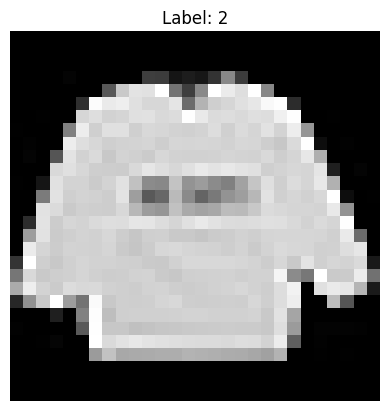

In [37]:
#visualising one image

# choosing the first image
image_array = X_train[0]
label = y_train[0]

# reshape 784 to 28x28
image_array = image_array.reshape(28, 28)

# plotting the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [38]:
# rescaling the pixel values down to values between 0 - 1 for efficiency of neural network

X_train = X_train / 255.0
X_test = X_test / 255.0

In [39]:
# one hot encoding for labels

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

print(y_train.shape)


(60000, 10)


In [40]:
# for reproducibility
np.random.seed(42)

# architecture of the neural network
input_nodes = X_train.shape[1]
hidden_nodes = 128
output_nodes = 10

In [76]:
# activation functions and its derivatives
class ReLU:
    def __init__(self):
        self.x_copy = None

    def forward(self, x):
        self.x_copy = x
        return np.maximum(0, x)

    def backward(self, dout):
        if self.x_copy > 0:
            return 1 * dout
        else:
            return 0


class Sigmoid:
    def __init__(self):
        self.x_copy = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        self.x_copy = x
        # consider clipping to prevent under / overflow
        return self.sigmoid(x)

    def backward(self, dout):
        return self.sigmoid(self.x_copy) * (1 - self.sigmoid(self.x_copy)) * dout


class Softmax:
    def __init__(self, crossEntropy=False):
        self.x_copy = None
        self.cross_entropy = crossEntropy

    def softmax(self, x):
        return np.exp(x) / np.exp(x).sum(axis=1)[:, np.newaxis]

    def forward(self, x):
        self.x_copy = x
        return self.softmax(x)

    def backward(self, dout):
        if self.cross_entropy:
            return dout
        else:
            # reshaping shape (m,) to (m,1) by doing [:, None] to allow broadcasting
            return self.softmax(self.x_copy) * (dout - (dout * self.softmax(self.x_copy)).sum(axis=1)[:, None])


class Linear:
    def __init__(self, input_num, output_num):
        self.db = None
        self.dw = None
        self.rng = np.random.default_rng(42)
        self.weights = self.rng.normal(size=(input_num, output_num)) * np.sqrt(2 / input_num)
        self.bias = np.zeros((1, output_num))
        self.X_copy = None

    def forward(self, X):
        self.X_copy = X
        return np.dot(X, self.weights) + self.bias

    def backward(self, dout):
        """
        Backward pass for the linear layer.
        Parameters:
            dout: Gradient of the loss with respect to the output (batch_size, output_num)
        Returns:
            dx: Gradient of the loss with respect to the input X (batch_size, input_num)
        """
        # Gradient with respect to weights
        dw = np.dot(self.X_copy.T, dout)  # Shape: (input_num, output_num)

        # Gradient with respect to biases
        db = np.sum(dout, axis=0)  # Shape: (1, output_num)

        # Gradient with respect to inputs
        dx = np.dot(dout, self.weights.T)  # Shape: (batch_size, input_num)

        # Save gradients for weight and bias updates
        self.dw = dw
        self.db = db

        return dx


class CrossEntropy:
    def __init__(self, softmax=False):
        self.y_pred_copy = None
        self.softmax = softmax

    def forward(self, y, y_pred):
        self.y_pred_copy = y_pred.clip(min=1e-8, max=None)
        return -np.mean(np.sum(y * np.log(self.y_pred_copy)))

    def backward(self, y):
        if self.softmax:
            return self.y_pred_copy - y
        # -y / y_pred / y.shape[0]
        return np.where(y == 1, - y / (self.y_pred_copy + 1e-15) / y.shape[0], 0)


In [77]:
# def create_weights(rows, cols):
#     # generate random numbers from normal distribution
#     return np.random.randn(rows, cols)

In [78]:
# w1 = create_weights(input_nodes, hidden_nodes)
# b1 = np.zeros((w1.shape[0], 1))
# 
# w2 = create_weights(hidden_nodes, output_nodes)
# b2 = np.zeros((w2.shape[0], 1))
# 
# print(w1.shape, b1.shape, w2.shape, b2.shape)

In [79]:
class NeuralNetwork:
    def __init__(self, layers, loss_fn, learning_rate):
        self.layers = layers
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        return

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        print(x.shape)
        return x

    def loss(self, y, y_pred):
        return self.loss_fn.forward(y, y_pred)

    def backward(self, y):
        grad = self.loss_fn.backward(y)
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)

    def update(self, X, y):
        return

    def predict(self, X):
        return

    def evaluate(self, X, y):
        return

In [80]:
model = NeuralNetwork([Linear(X_train.shape[1], 100), ReLU(), Linear(100, 10), Softmax(crossEntropy=True)],
                      CrossEntropy(softmax=True), 0.01)

y_pred = model.forward(X_train)
model.loss(y_train, y_pred)

(60000, 10)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


np.float64(15325.75856937663)

In [81]:
model.backward(y_train)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()